# Deep Learning - Handwritten Digit Calculator

In [4]:
"""
MIT License

Copyright (c) 2019 wblachowski

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


Link to dataset: https://github.com/wblachowski/bhmsds?fbclid=IwAR2WbJRLMxecP4a41iTjJR-_idug6anFvjFdz8XyinaZV7gA8OFwaah7MR8
"""

import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import random 
import os, os.path
import matplotlib.pyplot as plt                                     
import imutils                                                      #contours

from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary                                       #network description 
from sympy import *                                                 #symbolic mathematics

#use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#labels  
LABELS_DICT = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    'plus' : 10,
    'minus' : 11,
    'slash' : 12,
    'dot' : 13,
    'w' : 14,
    'x' : 15,
    'y' : 16,
    'z' : 17,
    }

INV_LABELS_DICS = {v: k for k, v in LABELS_DICT.items()}

tensor(1.)
tensor(2.0679e-08)
tensor(1.)
tensor(1.7638e-08)
tensor(1.)
tensor(1.2164e-08)
tensor(1.0000)
tensor(1.4597e-08)
tensor(1.0000)
tensor(3.7253e-09)
tensor(1.)
tensor(-2.4328e-08)
tensor(1.0000)
tensor(-4.5616e-09)
tensor(1.)
tensor(-2.7674e-08)
tensor(1.)
tensor(-3.6493e-09)
tensor(1.0000)
tensor(7.9067e-09)
tensor(1.)
tensor(6.0821e-10)
tensor(1.)
tensor(1.7638e-08)


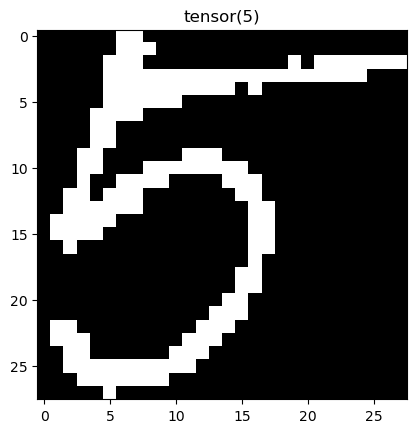

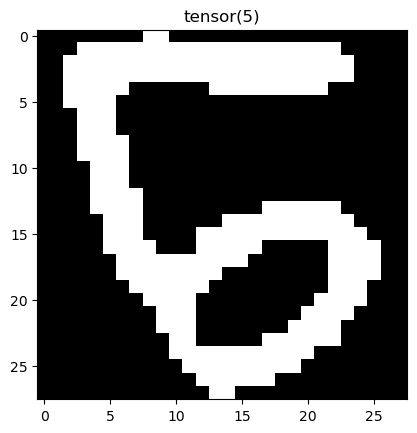

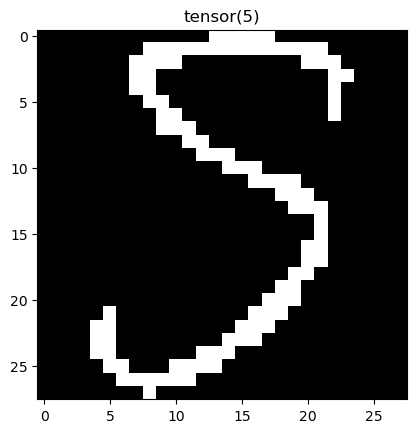

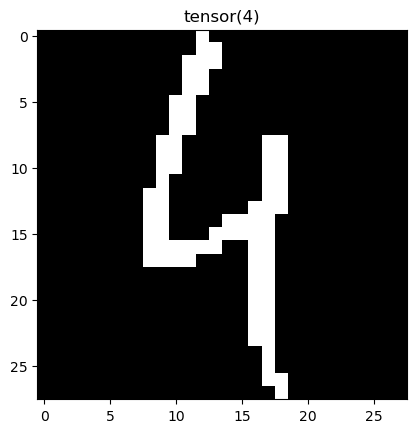

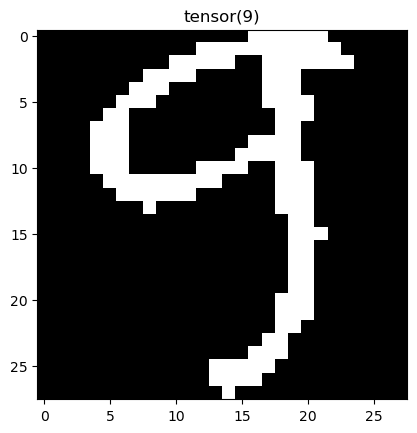

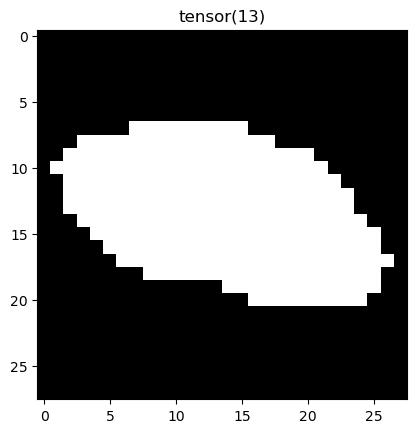

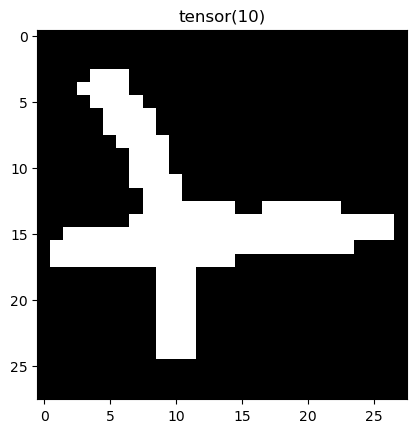

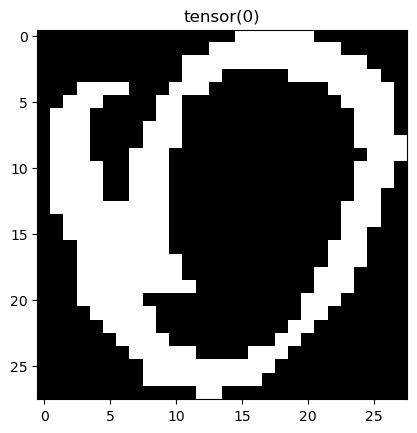

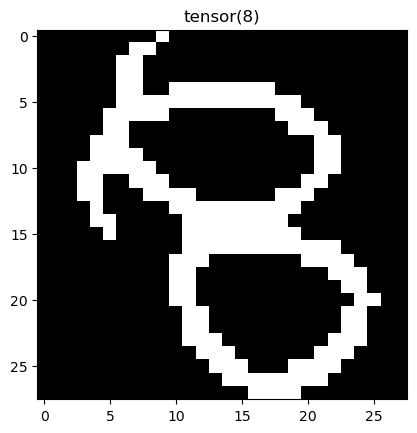

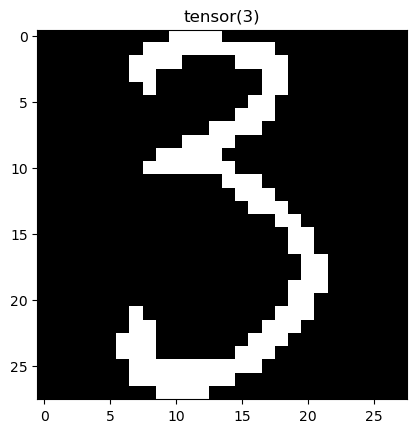

In [5]:
"""
CREATING CUSTOM DATASET
Data consist of: 
- Numbers from 1-9
- Operators: +, -, / and * 
- Letters: w, x, y, z

- Format of each image: <symbol-name>-<id>.png
- 1500 images of each type 
"""

class Digits(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        #image = cv2.resize(image, (32, 32))      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting from bgr to grayscale for faster computation 
        _ , image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        if self.transform:
            image = self.transform(image) 

            #normalizing tensor
            mean, std = torch.mean(image), torch.std(image)
            normalize = transforms.Normalize(mean, std)
            image = normalize(image)

        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        if self.target_transform:
            label = self.target_transform(label)
        
        return label

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        return image, label
    


#set up dataset
transform = transforms.Compose([transforms.ToTensor()]) 
dataset = Digits("data/symbols/", transform=transform)

datasetSize = dataset.__len__()
batch_size = 2 

#split data: 80% training, 10% validation, 10% test
test_train_data, test_validation_data, test_test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])

#creating data loaders
test_trainloader = DataLoader(test_train_data, batch_size=batch_size, shuffle=True, num_workers=0)


"""
GETTING SOME IMAGES FROM DATASET 
"""
dataiter = iter(test_trainloader)
images, labels = dataiter.next()

#run through 3 batches
for i in range(5): #Run through 5 batches
    images, labels = dataiter.next()
    for image, label in zip(images, labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(label)


In [12]:
"""
PREPARING DATA FOR TRAINING
"""
#normalizing data and one-hot encode
transform = transforms.Compose([transforms.ToTensor()])  

#create data
dataset = Digits("data/symbols/", transform=transform)
datasetSize = dataset.__len__()

batch_size = 128 

#split data: 80% training, 10% validation, 10% test
train_data, validation_data, test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])
#train_data, validation_data, test_data = random_split(dataset, [6500, 500, 20000])

#creating data loaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validateloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [15]:
"""
CNN NETWORK
"""
class Network(nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same', bias=True)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d() #dropout (type of regularization) avoids overfitting
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn5 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, num_classes)        
    
    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.bn1(x)
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)   #[batch size, 32, 14, 14]
        x = self.bn2(x)
        x = self.pool2(x)   #[batch size, 32, 7, 7]
        x = F.relu(x)
        x = self.conv3(x)   #[batch size, 64, 7, 7]
        x = self.bn3(x)
        x = self.pool3(x)   #[batch size, 64, 3, 3]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 64 * 3 * 3]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


#testing forward call 
testNetwork = Network(len(LABELS_DICT)).to(device)
print(summary(testNetwork, (1, 1, 28, 28)))

"""
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_data))
print(example_data.shape)
"""

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 18]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           9,248
├─BatchNorm2d: 1-5                       [1, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Conv2d: 1-7                            [1, 64, 7, 7]             18,496
├─BatchNorm2d: 1-8                       [1, 64, 7, 7]             128
├─MaxPool2d: 1-9                         [1, 64, 3, 3]             --
├─Flatten: 1-10                          [1, 576]                  --
├─Dropout2d: 1-11                        [1, 576]                  --
├─Linear: 1-12                           [1, 120]                  69,240
├─

c:\Users\emilh\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


'\nexamples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nprint(len(example_data))\nprint(example_data.shape)\n'

In [16]:
"""
TRAINING METHOD
"""
#lists to hold accuracy and loss - used for plotting 
training_losses = []
training_accuracy = []

def train(network, trainloader, optimizer, criterion, device):
    #variables accuracy and loss 
    size, batch_size = 0, 0
    training_correct, correct = 0, 0 

    #setting network to training mode 
    network.to(device)
    network.train()
    
    #training the model
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        #calculate predictions and loss
        output = network(data)
        loss = criterion(output, target)

        #backpropagate
        optimizer.zero_grad()   #1. sets gradients to zero
        loss.backward()         #2. compute new gradients using back propagation
        optimizer.step()        #3. update parameters with new gradients 

        #computing accuracy 
        correct = (output.argmax(1) == target).type(torch.float).sum().item()
        training_correct += correct
        batch_size = len(data)

        #storing loss 
        training_losses.append(loss.item())
        training_accuracy.append(correct / batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 25 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss.item()))
    #save internal state
    torch.save(network.state_dict(), "model.pth")
    #torch.save(optimizer.state_dict(), "optimizer.pth")

    #print training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")
    

In [17]:
"""
VALIDATION METHOD
"""
#lists to hold accuracy and loss - used for plotting 
validate_losses = []
validate_accuracy = []


def validate(network, validationloader, criterion, device):
    #variables
    size, batch_size = 0, 0
    validation_loss, loss = 0, 0
    validation_correct, correct = 0, 0

    num_batches = len(validationloader)

    #set network to testing mode
    network.to(device)
    network.eval()

    #validating the model 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validationloader):
            data, target = data.to(device), target.to(device)

            #getting batch size 
            batch_size = len(data)

            #predicting the output 
            output = network(data)

            #loss 
            loss = criterion(output, target)
            validation_loss += loss.item()
            validate_losses.append(loss.item())

            #accuracy
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            validation_correct += correct
            validate_accuracy.append(correct / batch_size)

            #updating size
            size += batch_size
        
    #calculate loss 
    validation_loss = validation_loss / num_batches

    #calculate accuracy   
    validation_correct = validation_correct / size

    #printing output of validation  
    print(f"Validation set: \n Accuracy: {(100 * validation_correct):>0.1f}%, Average loss: {validation_loss:>8f} \n")

In [18]:
"""
TRAINING AND VALIDATING  
"""
#hyperparameters
epochs = 10
learning_rate = 0.01
momentum = 0.5

num_classes = len(LABELS_DICT)

#instance of network model 
network = Network(num_classes=num_classes)

#optimizer and loss function 
criterion = nn.functional.cross_entropy   #default loss function for multi-class classifications problems         
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)


#training and validating the model
for iEpoch in range(epochs): 
    print(f"Epoch {iEpoch + 1}\n--------------------")

    train(network, trainloader, optimizer, criterion, device)
    validate(network, validateloader, criterion, device)


Epoch 1
--------------------
[0/21600 (0%)]	Loss: 3.063615
[12800/21600 (59%)]	Loss: 1.725593
Training accuracy: 53.8%
Validation set: 
 Accuracy: 84.1%, Average loss: 1.053826 

Epoch 2
--------------------
[0/21600 (0%)]	Loss: 1.166110
[12800/21600 (59%)]	Loss: 0.740796
Training accuracy: 85.0%
Validation set: 
 Accuracy: 93.6%, Average loss: 0.432063 

Epoch 3
--------------------
[0/21600 (0%)]	Loss: 0.569884
[12800/21600 (59%)]	Loss: 0.440533
Training accuracy: 91.2%
Validation set: 
 Accuracy: 95.7%, Average loss: 0.248967 

Epoch 4
--------------------
[0/21600 (0%)]	Loss: 0.343075
[12800/21600 (59%)]	Loss: 0.312824
Training accuracy: 93.1%
Validation set: 
 Accuracy: 96.7%, Average loss: 0.166908 

Epoch 5
--------------------
[0/21600 (0%)]	Loss: 0.325082
[12800/21600 (59%)]	Loss: 0.241725
Training accuracy: 94.4%
Validation set: 
 Accuracy: 96.9%, Average loss: 0.133153 



Text(0, 0.5, 'Validation loss')

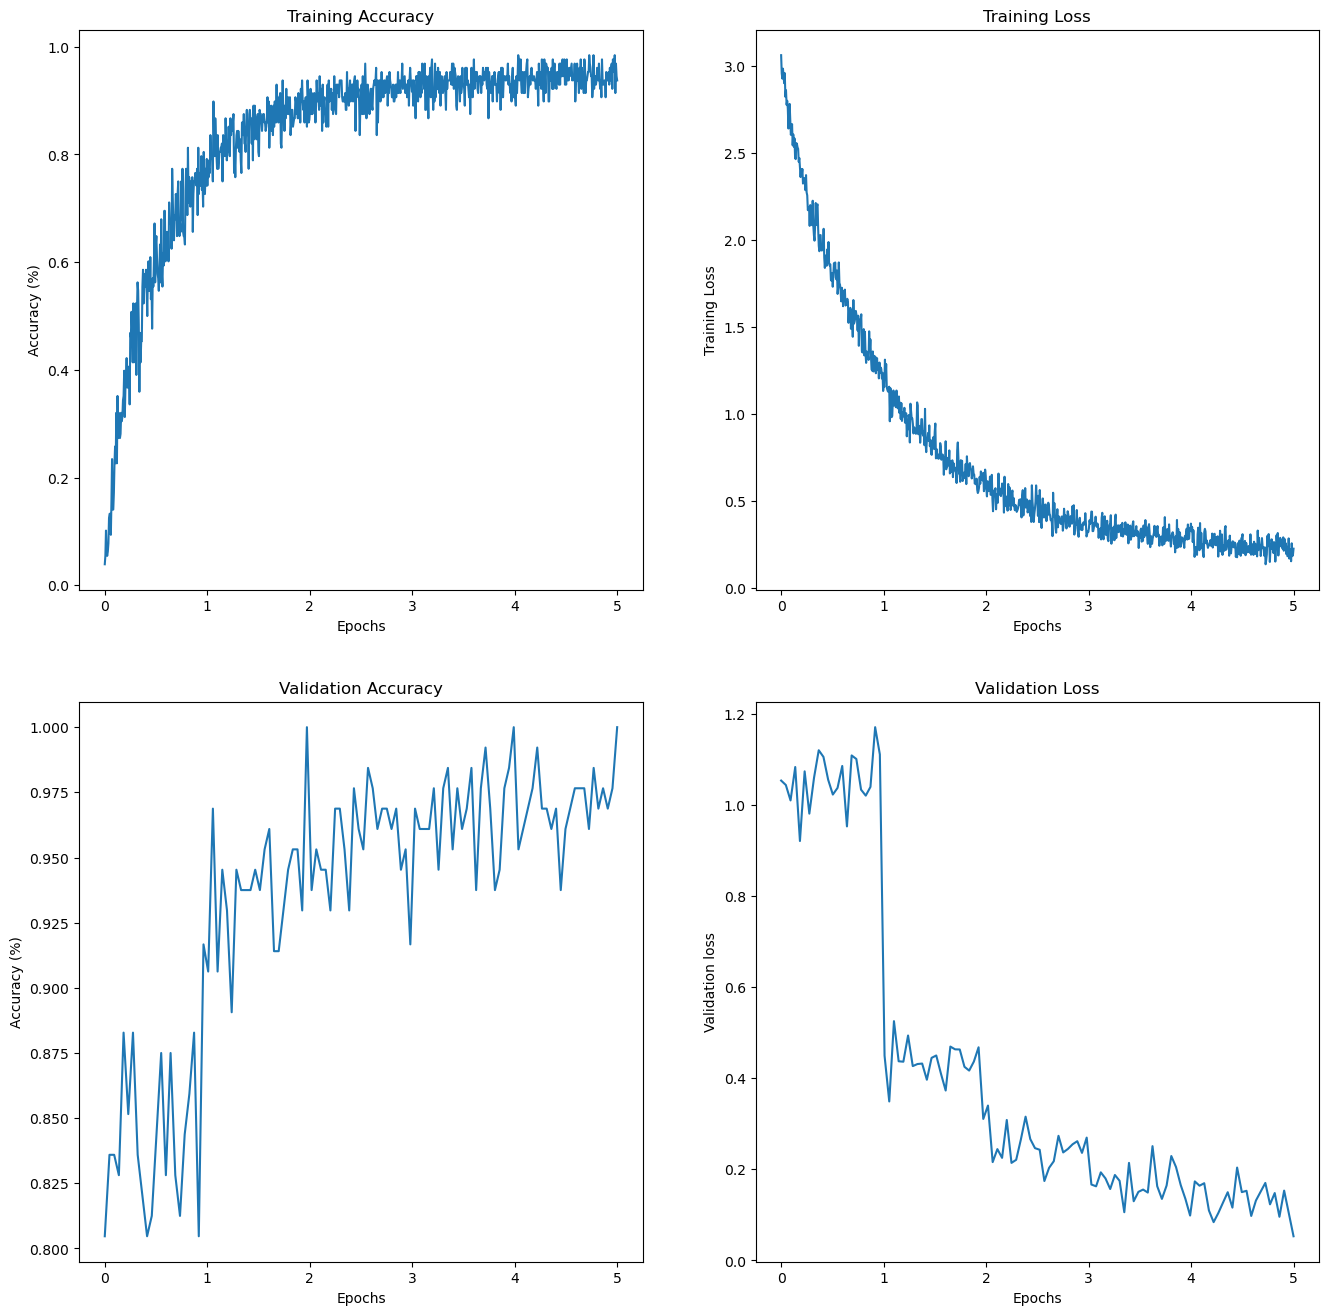

In [19]:
"""
PLOTTING RESULTS
"""
figure = plt.figure(figsize=(16, 16))
 
epochs_training = np.linspace(0, epochs, len(training_accuracy))
epochs_validation = np.linspace(0, epochs, len(validate_accuracy))

#training accuracy
figure.add_subplot(2, 2, 1)
plt.plot(epochs_training, training_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

#training loss
figure.add_subplot(2, 2, 2)
plt.plot(epochs_training, training_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")


#validation accuracy 
figure.add_subplot(2, 2, 3)
plt.plot(epochs_validation, validate_accuracy)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")


#validation loss
figure.add_subplot(2, 2, 4)
plt.plot(epochs_validation, validate_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")


In [20]:
"""
TESTING
"""
def evaluate(network, testloader, criterion, device):    
    test_loss, loss = 0, 0
    test_correct, correct = 0, 0

    #switching to eval mode 
    network.to(device)
    network.eval()

    #testing the model
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            #predicting output using model 
            output = network(data)
            predicted_label = output.cpu().data.max(1, keepdim=True)[1].item() 
        
            #update loss
            loss = criterion(output, target)
            test_loss += loss.item()

            #calculate correct 
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            test_correct += correct

            #randomly show test image and prediction  
            if (random.randint(0, 100) == 25):
                test_image = data.cpu().data.squeeze().numpy()
                test_image = cv2.resize(test_image, (800, 800))

                #print image 
                cv2.imshow("Test image", test_image)
                print("Target label: ", target.cpu().item())
                print("Predicted label: ", predicted_label)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    
    #calculate average loss
    test_loss = test_loss / len(testloader.dataset)
    
    #printing 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                test_correct, 
                                                                                len(testloader.dataset), 
                                                                                100. * test_correct / len(testloader.dataset)))

#getting previous internal state of model 
model = Network(num_classes=num_classes)
model.load_state_dict(torch.load("model.pth"))

#testing the model
evaluate(model, testloader, criterion, device)



Target label:  5
Predicted label:  5
Target label:  13
Predicted label:  13
Target label:  5
Predicted label:  5
Target label:  16
Predicted label:  16
Target label:  1
Predicted label:  1
Target label:  15
Predicted label:  15
Target label:  0
Predicted label:  0
Target label:  0
Predicted label:  0
Target label:  8
Predicted label:  8
Target label:  10
Predicted label:  10
Target label:  9
Predicted label:  9
Target label:  16
Predicted label:  16
Target label:  9
Predicted label:  9
Target label:  10
Predicted label:  10
Target label:  14
Predicted label:  14
Target label:  7
Predicted label:  7
Target label:  12
Predicted label:  12
Target label:  2
Predicted label:  2
Target label:  5
Predicted label:  5
Target label:  10
Predicted label:  10
Target label:  7
Predicted label:  7
Target label:  1
Predicted label:  1
Target label:  14
Predicted label:  14
Target label:  8
Predicted label:  8
Target label:  6
Predicted label:  6
Target label:  3
Predicted label:  3
Target label:  17


In [21]:
"""
Helper functions
"""
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
  
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
  
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
  
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
  
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


#function to convert image to tensor 
def convert_to_tensor(image):
    image = cv2.resize(image, (28, 28))      

    #transform to tensor 
    trans = transforms.Compose([transforms.ToTensor()])
    tensor_image = trans(image)

    #normalizing tensor
    mean, std = torch.mean(tensor_image), torch.std(tensor_image)
    normalize = transforms.Normalize(mean, std)
    tensor_image = normalize(tensor_image)

    return tensor_image

    

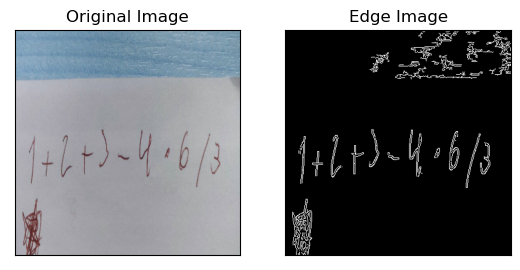

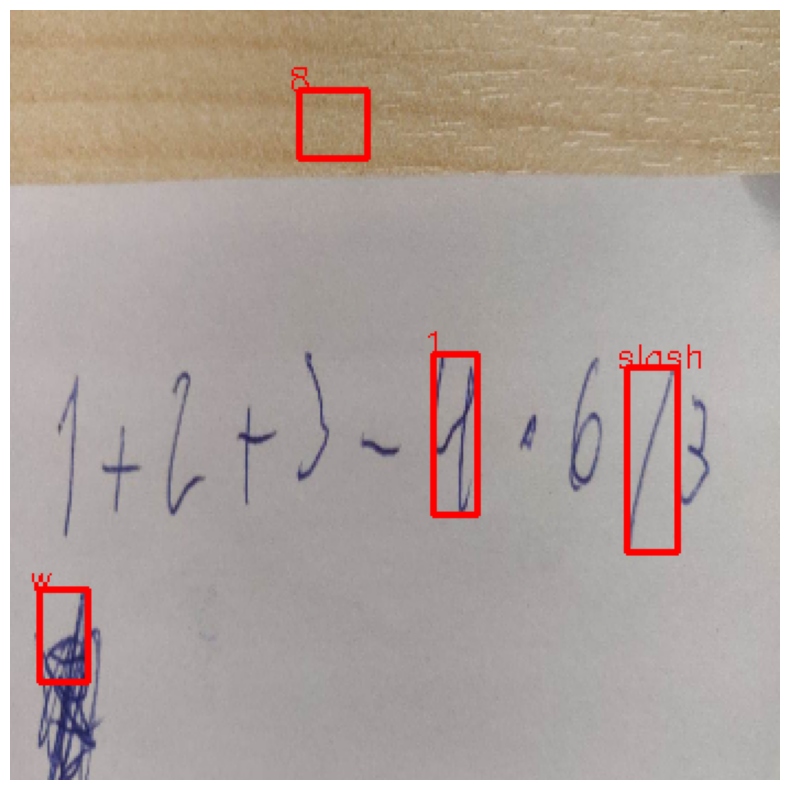

In [22]:
"""
TEST IMAGE ON EXPRESSION
"""
def pipeline_expression(image_path, network):
    #predictions 
    predictions = []

    #set up network
    network.to(device)
    network.eval()
    
    #process main image 
    image = cv2.imread(image_path)
    image = cv2.resize(image,(500, 500))                    #resize expression image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    #grayscale image 
    edged = cv2.Canny(image_gray, 30, 150)                  #detect edges (min val: 30, max val: 150 - maybe change later?)

    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #detecting contours 
    contours = imutils.grab_contours(contours)                                              #only getting the contours
    contours = sort_contours(contours, method="left-to-right")[0]                           #sorting from left to right
    
    #edged image 
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edged, cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
         
    #plot contours
    #cv2.drawContours(image, contours, -1, (0,255,0), 3)
    #cv2.imshow("title", image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    with torch.no_grad():
        #converting contour -> image -> tensor
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)  #getting bounding boxes

            #determining the dimensions of the padded image 
            if 20 <= w and 30 <= h:
                roi = image_gray[y:y+h, x:x+w]
                thresh = cv2.threshold(roi, 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                (th, tw) = thresh.shape

                if tw > th:
                    thresh = imutils.resize(thresh, width=28)

                if th > tw:
                    thresh = imutils.resize(thresh, height=28)
                
                (th, tw) = thresh.shape

                dx = int(max(0, 28 - tw) / 2.0)
                dy = int(max(0, 28 - th) / 2.0)

                #creates border around image - output is an image
                padded_image = cv2.copyMakeBorder(thresh, 
                                                top=dy, 
                                                bottom=dy, 
                                                left=dx, 
                                                right=dx, 
                                                borderType=cv2.BORDER_CONSTANT, 
                                                value=(0, 0, 0))
                #prints padded images 
                #cv2.imshow("Padded", padded_image)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
        
                #convert images to tensors
                tensor_image = convert_to_tensor(padded_image)  #image dimensions: [1, 28, 28]
                tensor_image = tensor_image.unsqueeze(0)        #image dimensions: [1, 1, 28, 28]
                tensor_image = tensor_image.to(device)
                
                #predict output
                output = network(tensor_image)
                predicted_label = output.data.max(1, keepdim=True)[1].item()

                #convert and store
                label = INV_LABELS_DICS[predicted_label]
                predictions.append(label)

                #add rectangles and prediction to the image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(image, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
    
    #printing image with bounding boxes
    figure = plt.figure(figsize=(10,10))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    return predictions
    

"""
Testing the pipeline
"""
#getting previous internal state of model 
model = Network(num_classes=num_classes)
model.load_state_dict(torch.load("model.pth"))

#test images
test_image_path1 = "test1.png"
test_image_path2 = "test2.png"
test_image_path3 = "test3.png"
test_image_path4 = "test4.png"
test_image_path5 = "test5.png"
test_image_path6 = "test6.png"
test_image_path7 = "test7.png"
test_image_path9 = "test9.png"

#testing the images 
predictions1 = pipeline_expression(test_image_path1, model)
predictions2 = pipeline_expression(test_image_path2, model)
predictions3 = pipeline_expression(test_image_path3, model)
predictions4 = pipeline_expression(test_image_path4, model)
predictions5 = pipeline_expression(test_image_path5, model)
predictions6 = pipeline_expression(test_image_path6, model)
predictions7 = pipeline_expression(test_image_path7, model)
predictions9 = pipeline_expression(test_image_path9, model)



In [16]:

"""
CALCULATOR METHOD
"""
#letters in dataset
x, y, z, w = symbols('x y z w')


def calculator(predictions):
    e = ""                      #variable to hold final handwritten expression 
    unknown_variable = False    #keep track of unknown variable
    i = 0                       #counter

    while i < (len(predictions)):
        #check for unknown variable in expression 
        if predictions[i] == 'x' or predictions[i] =='y' or predictions[i] =='z' or predictions[i] =='w':
          unknown_variable = True

        #add plus 
        if predictions[i] == 'plus':
            e += '+'

        #add equal sign if two minus sign is next to each other
        elif predictions[i] == 'minus'and predictions[i + 1] =='minus':
          e += '='
          i += 1
        
        #add minus 
        elif predictions[i] == 'minus':
            e += '-'
        
        #add division
        elif predictions[i] == 'slash':
            e += '/'
        
        #add multiplication 
        elif predictions[i] == 'dot':
            e += '*'
        
        #add number 
        else:
            e += predictions[i]
        
        i += 1

    #if there is an unknown letter in expression, then use sympify/solve functions to calculate expression 
    if unknown_variable == True:
       eq = ''.join(e)
       print("The equation is:",eq)
       gfg_exp = sympify("Eq(" + eq.replace("=", ",") + ")")

       # Use sympy.integrate() method
       intr = solve(gfg_exp, x, y, z, w,dict=True)
       print("The solution is {}".format(intr))

    #otherwise simply use eval function to calculate expression 
    else:
      result = eval(e)
      print("Expression: ", e)
      print("Result: ", result)


#testing the calculator on predictions 
calculator(predictions1)
calculator(predictions2)
calculator(predictions3)
calculator(predictions4)
calculator(predictions5)
calculator(predictions6)
calculator(predictions7)



Expression:  3540
Result:  3540


SyntaxError: invalid syntax (<string>, line 1)

### Sources
Creation of custom dataset
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Network and Training
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
- https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc


Calculator and Pipeline 
- https://medium.com/ai-techsystems/handwritten-optical-character-recognition-calculator-using-cnn-and-deep-learning-fcc432f88b63
- https://www.sympy.org/en/index.html